In [4]:
import numpy as np
import matplotlib.pyplot as plt

from hierarchical import HierarchicalForest
from sklearn.ensemble import RandomForestClassifier as RF

from tqdm import tqdm

from joblib import Parallel, delayed

In [5]:
def generate_hierarchical_gaussian_data(n_clusts=2, n_dists_per_clust=2, d=2, clust_cov=1, n_train=25, n_test=100, dist_cov=0.5, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    all_means = [
        np.array([1,1]),
        np.array([-1,-1]),
        np.array([1, -1]),
        np.array([-1, 1])
    ]
    
    clust_means = all_means[:n_clusts]
    clust_cov = clust_cov * np.eye(d)
    
    dist_means = [np.random.multivariate_normal(clust_means[i], clust_cov, size=n_dists_per_clust) for i in range(n_clusts)]

        
    dist_cov = dist_cov * np.eye(d)
    
    train_data = np.concatenate(np.concatenate([
        [np.random.multivariate_normal(dist_means[i][j], dist_cov, size=n_train) for j in range(n_dists_per_clust)] 
            for i in range(n_clusts)]))
    y_train = np.concatenate([i * np.ones(n_train) for i in range(n_dists_per_clust * n_clusts)])
    
    test_data = np.concatenate(np.concatenate([
        [np.random.multivariate_normal(dist_means[i][j], dist_cov, size=n_test) for j in range(n_dists_per_clust)] 
            for i in range(n_clusts)]))
    y_test = np.concatenate([i * np.ones(n_test) for i in range(n_dists_per_clust * n_clusts)])
            
    return train_data, y_train, test_data, y_test

In [6]:
def label_noise_exp(label_noise=0, n_train=25, n_test=100, n_clusts=4, n_dists_per_clust=8):
    
    accuracies = np.zeros(2)
    x_train, y_train, x_test, y_test = generate_hierarchical_gaussian_data(n_clusts=n_clusts, n_dists_per_clust=n_dists_per_clust, d=2, clust_cov=1,
                                                                          n_train=25, n_test=100, dist_cov=0.5)
    
    idx_to_change = np.random.binomial(1, p=label_noise, size=n_train * n_clusts * n_dists_per_clust).astype(bool)
    new_labels = np.array([np.random.choice(np.unique(y_train), size=1)[0] for bool_ in idx_to_change if bool_])
    
    y_train[idx_to_change] = new_labels
    
    fine_to_coarse = np.concatenate([i * np.ones(n_dists_per_clust) for i in range(n_clusts)])
    hf = HierarchicalForest(fine_to_coarse=fine_to_coarse, n_estimators_coarse=25, n_estimators_fine=50, max_depth=None)
    hf.fit(x_train, y_train)
    accuracies[0] = np.mean(hf.predict(x_test) == y_test)
    
    rf = RF(n_estimators=225)
    rf.fit(x_train, y_train)
    accuracies[1] = np.mean(rf.predict(x_test)  == y_test)
    
    return accuracies

In [7]:
np.random.seed(1)

n_clusts=4
n_dists_per_clust = 4

n_train=25
n_test=100

label_noise_list = [0, 0.1, 0.2, 0.3, 0.5, 0.8]

n_cores=10

accuracies = []

n_mc=100
for i, p in enumerate(tqdm(label_noise_list)):
    f = lambda x: label_noise_exp(p, n_train, n_test, n_clusts, n_dists_per_clust)
    accuracies.append(Parallel(n_jobs=n_cores)(delayed(f)(_) for _ in range(n_mc)))
    
accuracies = np.array(accuracies)

100%|██████████| 6/6 [01:22<00:00, 13.73s/it]


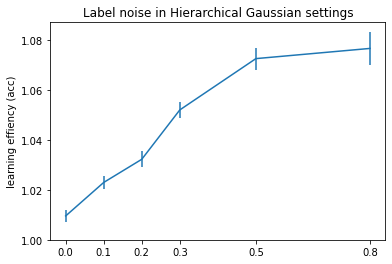

In [10]:
mean_le = np.mean(accuracies[:, :, 0] / accuracies[:, :, 1], axis=1)
std_le = np.std(accuracies[:, :, 0] / accuracies[:, :, 1], axis=1) / np.sqrt(n_mc)

fig, ax = plt.subplots(1,1)

ax.errorbar(label_noise_list, mean_le, yerr=std_le)

ax.set_title('Label noise in Hierarchical Gaussian settings')
ax.set_ylabel('learning effiency (acc)')

ax.set_xticks(label_noise_list)
ax.set_yticks([1, 1.02, 1.04, 1.06, 1.08])